In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2


In [3]:
def crop_image(img_dir)->str:
    '''
    Image cropped from left to right to have a width of 768 pixels.
    The image is cropped from the bottom up to the first row with non-black pixels.
    arg: 
            img_dir (str): The file path to the image to crop.
    return: 
            cropped_img (numpy.ndarray): The cropped image.
    '''
    img = cv2.imread(img_dir)
    gray = img
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # annotation region starts at x=0 and ends at x=767 (adjust as needed)
    x_end = gray.shape[1]           # rightmost pixel
    x_start = x_end - 767 
    y_start = 0
    y_end = gray.shape[0]  # full height for now

    # Crop image
    X_cropped_img = gray[y_start:y_end, x_start:x_end]

    gray = X_cropped_img
    x_start_crop = 200
    x_end_crop = 400

    # Scan from bottom up to find the first row with non-black pixels in the x-range
    for y in range(gray.shape[0] - 1, -1, -1):
        row_pixels = gray[y, x_start_crop:x_end_crop]
        if np.any(row_pixels > 10):  # threshold for "not black"
            bottom_crop = y + 1  # +1 to include the first non-black row
            break
    else:
        bottom_crop = gray.shape[0]  # fallback: no gray found

    # Crop the image from the top to bottom_crop
    Y_cropped_img = gray[0:bottom_crop, :]

    return Y_cropped_img


In [18]:
def plot_layer_annotations_on_image(img, lyr_dir, bscan_idx=0, min_annotation=0, max_annotation=2181818) -> None:
    """
    Plots retinal layer annotations over a B-scan image.

    Args:
        img_path (str): Path to the cropped B-scan image.
        lyr_dir (str): Path to the annotation .xls/.csv file.
        bscan_idx (int): Index of the B-scan to plot (default: 0).
        min_annotation (float): Minimum annotation value for scaling (default: 60000).
        max_annotation (float): Maximum annotation value for scaling (default: 1963636).
    """
    import cv2
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    # Load the cropped image

    #img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Load annotation data
    if lyr_dir.endswith('.xls') or lyr_dir.endswith('.xlsx'):
        data = pd.read_csv(lyr_dir, sep=None, engine='python')
    else:
        data = pd.read_csv(lyr_dir)


    layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']
    row_idx = 1 + (bscan_idx * 34)
    start_row = row_idx + 2
    layer_rows = [start_row + i * 3 for i in range(len(layers))]

    plt.figure(figsize=(15, 10))
    plt.imshow(img, cmap='gray', alpha=0.8)
    colors = plt.cm.tab10(np.linspace(0, 1, len(layers)))

    for i, (layer, row_idx_layer) in enumerate(zip(layers, layer_rows)):
        layer_data = data.iloc[row_idx_layer - 1, 0:767].values
        y = pd.to_numeric(layer_data, errors='coerce')
        y_scaled = (y - min_annotation) * (img.shape[0] / (max_annotation - min_annotation))
        x = np.arange(len(y_scaled))
        valid_mask = ~np.isnan(y_scaled)
        x_valid = x[valid_mask]
        y_valid = y_scaled[valid_mask]
        plt.plot(x_valid, y_valid, label=layer, linewidth=2, color=colors[i])

    plt.title(f'Cropped B-scan with Annotation Overlay ')
    plt.xlabel('A-Scan Index (Image Width)')
    plt.ylabel('Depth (pixels)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [11]:
# Function to get the pixel value of the micron scale bar 
# the scale bar is 200 microns long and is located between 500-550 pixel width and 400-500 pixel height
#use opencv to get the scale bar height(yaxis) and get the total pixel height of the scale bar
def get_scale_bar_pixel_length(img):
    """
    Returns the pixel length of the 200 micron scale bar in the image.
    The scale bar is located between 500-550 pixel width and 400-500 pixel height.
    """
    # Crop the region containing the scale bar
    scale_bar_region = img[400:500, 500:550]
    # Convert to binary: scale bar is white, background is black
    _, binary = cv2.threshold(scale_bar_region, 200, 255, cv2.THRESH_BINARY)
    # Sum along y-axis to get the horizontal bar
    horizontal_sum = np.sum(binary, axis=0)
    # Find where the bar exists (non-zero columns)
    bar_indices = np.where(horizontal_sum > 0)[0]
    if len(bar_indices) == 0:
        print("Scale bar not found.")
        return None
    # Pixel length of the scale bar
    pixel_length = bar_indices[-1] - bar_indices[0] + 1
    return pixel_length

# Example usage:
# img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
# scale_bar_pixels = get_scale_bar_pixel_length(img)
# print(f"Scale bar length: {scale_bar_pixels} pixels")

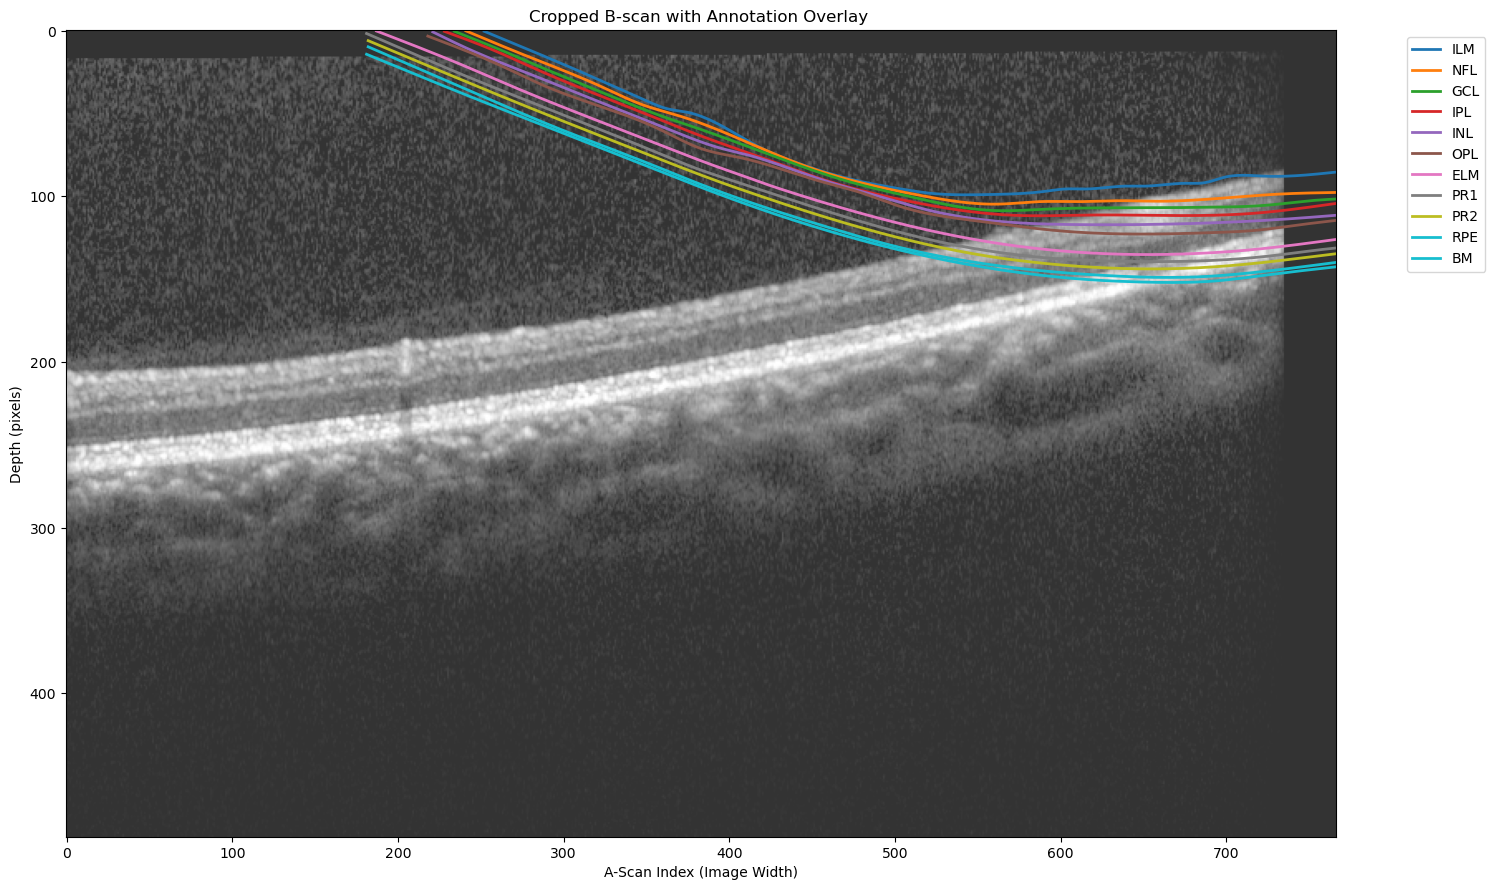

In [ ]:
img_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data-99R/99_R_2_1015.jpg'
lyr_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data-99R/99_R_2_1_Segm.xls'

image = crop_image(img_dir)
plot_layer_annotations_on_image(image, lyr_dir, bscan_idx=0)

In [24]:
#TEST
# get the image pixel dimensions
img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
height, width = img.shape
print(f"Image dimensions: {width} pixels wide, {height} pixels high")

Image dimensions: 2032 pixels wide, 596 pixels high


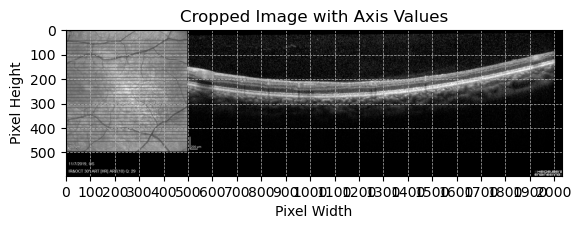

In [25]:
#TEST
# plot the image with axis values
plt.imshow(img, cmap='gray')
plt.axis('on')
#get more detailed axis values
plt.xticks(np.arange(0, width, step=100))
plt.yticks(np.arange(0, height, step=100))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Cropped Image with Axis Values')
plt.xlabel('Pixel Width')
plt.ylabel('Pixel Height')
plt.show()

In [12]:
scale_bar_pixels = get_scale_bar_pixel_length(img)
print(f"Scale bar length: {scale_bar_pixels} pixels")

Scale bar length: 44 pixels


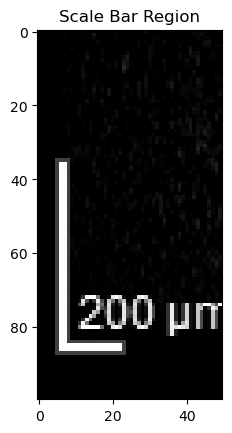

Scale bar length: 44 pixels


In [ ]:
#TEST Visualize the scale bar region and overlay detected bar
scale_bar_region = img[400:500, 500:550]
plt.imshow(scale_bar_region, cmap='gray')
plt.title('Scale Bar Region')
plt.show()

print(f"Scale bar length: {scale_bar_pixels} pixels")

In [27]:
#Calculate the micron length of the image
micron_per_pixel = 200/scale_bar_pixels
total_micron_height = micron_per_pixel * image.shape[0]*1000
print(f"Total height in microns: {total_micron_height:.4f} microns")
print(f"Microns per pixel: {micron_per_pixel:.4f} microns")

Total height in microns: 2213636.3636 microns
Microns per pixel: 4.5455 microns


Scale bar length: 44 pixels
Image dimensions: 767 pixels wide, 496 pixels high
Total height in microns: 2254545.4545 microns
Microns per pixel: 4.5455 microns


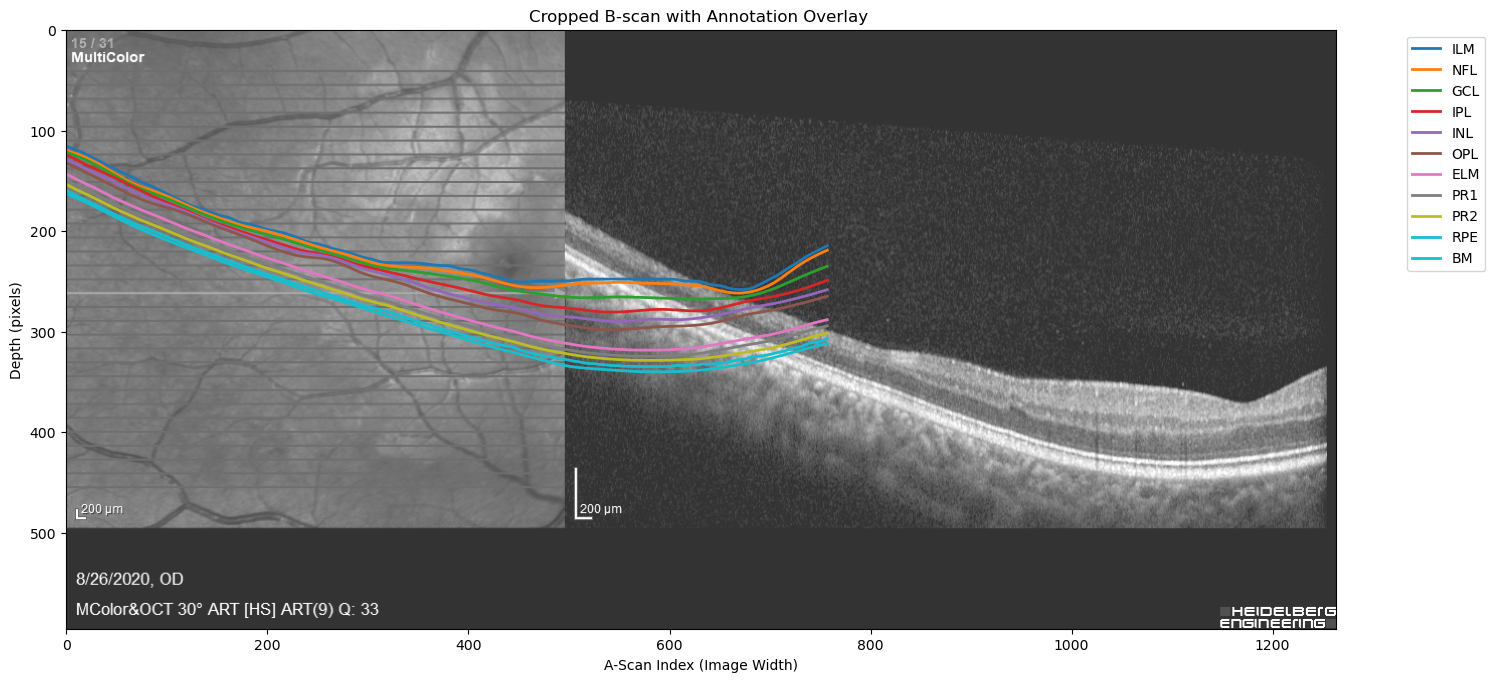

In [41]:
img_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data-99R/99_R_2_1014.jpg'
lyr_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data-99R/99_R_2_1_Segm.xls'

img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
scale_bar_pixels = get_scale_bar_pixel_length(img)
print(f"Scale bar length: {scale_bar_pixels} pixels")

image = crop_image(img_dir)
height, width = image.shape[:2]
print(f"Image dimensions: {width} pixels wide, {height} pixels high")

micron_per_pixel = 200/scale_bar_pixels
total_micron_height = micron_per_pixel * height * 1000
print(f"Total height in microns: {total_micron_height:.4f} microns")
print(f"Microns per pixel: {micron_per_pixel:.4f} microns")

plot_layer_annotations_on_image(img, lyr_dir, bscan_idx=14,min_annotation= 000,max_annotation=total_micron_height)


In [47]:
img_dir = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data-99R/99_R_2_1014.jpg'
data_path = '/home/suraj/Git/SCR-Progression/Lab-Data-Annotations/data-99R/99_R_2_1_Segm.xls'

img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

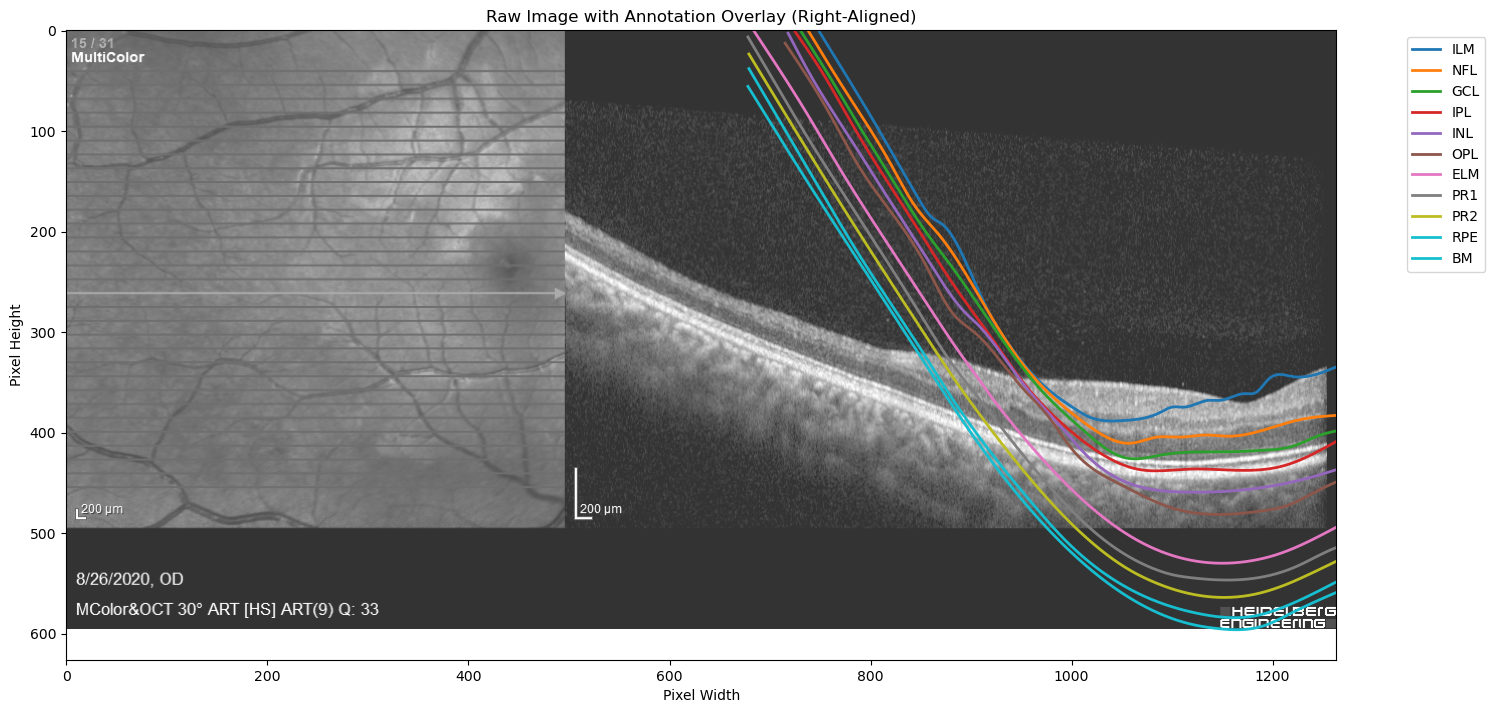

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# img: raw image loaded with cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# data_path: path to annotation file (CSV/XLS)

# Load annotation data
if data_path.endswith('.xls') or data_path.endswith('.xlsx'):
    data = pd.read_csv(data_path, sep=None, engine='python')
else:
    data = pd.read_csv(data_path)

img_height, img_width = img.shape
ann_length = 767  # number of annotation points

# Define layers and layer_rows (make sure bscan_idx is set)
layers = ['ILM', 'NFL', 'GCL', 'IPL', 'INL', 'OPL', 'ELM', 'PR1', 'PR2', 'RPE', 'BM']
bscan_idx = 0  # set your desired B-scan index
row_idx = 1 + (bscan_idx * 34)
start_row = row_idx + 2
layer_rows = [start_row + i * 3 for i in range(len(layers))]

x_img = np.arange(img_width - ann_length, img_width)  # map annotation x to rightmost part of image

# Collect all annotation values from all layers
all_y_values = []
for row_idx_layer in layer_rows:
    layer_data = data.iloc[row_idx_layer - 1, 0:ann_length].values
    y = pd.to_numeric(layer_data, errors='coerce')
    all_y_values.extend(y[~np.isnan(y)])

min_ann = np.nanmin(all_y_values)
max_ann = np.nanmax(all_y_values)

plt.figure(figsize=(15, 10))
plt.imshow(img, cmap='gray', alpha=0.8)

colors = plt.cm.tab10(np.linspace(0, 1, len(layers)))
for i, (layer, row_idx_layer) in enumerate(zip(layers, layer_rows)):
    layer_data = data.iloc[row_idx_layer - 1, 0:ann_length].values
    y = pd.to_numeric(layer_data, errors='coerce')
    y_scaled = (y - min_ann) * (img_height / (max_ann - min_ann))
    x = x_img
    valid_mask = ~np.isnan(y_scaled)
    plt.plot(x[valid_mask], y_scaled[valid_mask], label=layer, linewidth=2, color=colors[i])

plt.title('Raw Image with Annotation Overlay (Right-Aligned)')
plt.xlabel('Pixel Width')
plt.ylabel('Pixel Height')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()